# Detecting Drivers of Anomalous Backscattering with Multiple Regression 

This notebooks show the application of regression analysis on big EO datasets. In this study we want to better understand the causes of "anomalous" backscattering of Sentinel-1 microwaves from soils. Anomalous backscattering contrasts with the situation where microwaves recorded by Sentinel-1 sensors are governed by the soil's moisture content. The latter "normal" backscattering behavior is governed by the dielectric contrast at the air--soil interface in wet soils [1]. The cause of anomalous backscattering is less well-known but is generally thought to relate to deeper penetration of microwaves in dry soils and volume scattering effects by the presence of rocks or distinct horizons in soils [2, 3].

Hence we want to identify what factors might cause "anomalous" backscattering and we do this by applying a regression model to `rsub` (a metric for anomalous backscattering of Sentinel-1) and a set of soil characteristics.

In [1]:
%matplotlib inline

import time
from pathlib import Path
from IPython.display import display, Math

import ee
import geemap

import xarray as xr
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask_geopandas as dgpd
import geopandas as gpd
from shapely.geometry import Point
from pandas.api.types import CategoricalDtype
from dask_ml.preprocessing import Categorizer, DummyEncoder, PolynomialFeatures

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance

import datashader as ds
from datashader.mpl_ext import dsshow, alpha_colormap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import rasterio

/opt/conda/envs/01_multiple-regression/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


## Loading Dask Dataframe

For this analysis we want to explain the causes of anomalous backscattering quantified with the metric `rsub` at 20 meter resolution [4]. This is a temporal correlation between Sentinel-1 backscatter timeseries and reference soil moisture data from [ERA5Land](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land) provided by the European Center for Medium-Range Weather Forecasts (ECMWF) at 9 km resolution. In an attempt to explain anomalies in backscatter data we use the long term dryness of soils (`sm`) as measured by the mean soil moisture content over the last 30 years based on ERA5Land soil moisture data and the coarse fragment content of the soil from the Soil and Landscape Grid of Australia ([SLGA](https://esoil.io/TERNLandscapes/Public/Pages/SLGA/index.html)) at a 90 meter resolution.

The data is derived from a strip along the 21 southern latitude (close to tropic of capricorn 23 S, Figure 1) spanning all the way from the western to the eastern most part of Australia, thereby covering climatic zones from wet at the coast and dry in the interiors of Australia (Figure 1).

![](https://www.yourhome.gov.au/sites/default/files/inline-images/PD_Design_Climate_2.png)

*Figure 1: Australian climate zones (Source: [yourhome.gov.au](https://www.yourhome.gov.au/sites/default/files/inline-images/PD_Design_Climate_2.png)). See website for legend of climate zones.*

This data has already been collected in a Parquet data structure and can be lazily loaded, like so:

In [2]:
soil_df = dd.read_parquet("../shared/datasets/rs/S1_ERA5L_CRRL/CRRL-SIG0-ERA5L/V3")
soil_df

,x,y,depth,rsub,sm,sm005,sm095,des,cfg,cly,slt,snd,soc,tile
npartitions=3,,,,,,,,,,,,,,
,float32,float32,string,float32,float32,float32,float32,float32,int8,int8,int8,int8,int8,string
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


The data is partitioned into 3 partitions and close to 15 thousand observations, and is only loaded into memory when explicitly required. For example, when viewing the first 5 observations with `head`.

In [3]:
soil_df.head()

,x,y,depth,rsub,sm,sm005,sm095,des,cfg,cly,slt,snd,soc,tile
0,5287065.0,6599775.0,000_005,0.0748,0.070610,0.055128,0.189028,0.57,1,5,3,91,0,E051N063T3
1,5287065.0,6599775.0,005_030,0.0748,0.070717,0.059097,0.186019,0.57,1,6,3,91,0,E051N063T3
2,5287245.0,6599595.0,000_005,0.0730,0.070610,0.055128,0.189028,0.62,1,5,3,91,1,E051N063T3
3,5287245.0,6599595.0,005_030,0.0730,0.070717,0.059097,0.186019,0.62,1,6,3,91,0,E051N063T3
4,5287875.0,6598875.0,000_005,0.1730,0.070610,0.055128,0.189028,0.56,1,6,4,91,1,E051N063T3


In [4]:
soil_df.describe().compute()

,x,y,rsub,sm,sm005,sm095,des,cfg,cly,slt,snd,soc
count,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07
mean,6.632652e+06,6.987962e+06,1.919581e-01,8.960266e-02,7.068924e-02,1.593040e-01,8.128905e-01,1.958792e+00,1.890495e+01,1.047437e+01,7.027443e+01,3.294696e-02
std,8.959038e+05,3.953529e+05,1.403174e-01,5.567458e-02,5.435658e-02,6.875274e-02,5.972769e-01,1.252553e+00,7.107643e+00,3.292078e+00,9.680240e+00,1.920030e-01
min,5.145675e+06,4.914015e+06,1.000000e-04,9.994503e-03,1.104665e-05,9.994503e-03,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.773215e+06,6.887175e+06,8.710000e-02,6.606805e-02,2.004807e-02,1.161746e-01,3.900000e-01,1.000000e+00,1.400000e+01,8.000000e+00,6.800000e+01,0.000000e+00
50%,6.325695e+06,7.034265e+06,1.822000e-01,1.163286e-01,5.911957e-02,1.750134e-01,8.000000e-01,1.000000e+00,1.700000e+01,1.000000e+01,6.900000e+01,0.000000e+00
75%,7.500045e+06,7.257135e+06,2.965000e-01,1.766421e-01,1.557230e-01,2.496945e-01,1.130000e+00,4.000000e+00,3.100000e+01,1.300000e+01,7.700000e+01,0.000000e+00
max,9.184815e+06,8.595105e+06,8.835000e-01,4.632420e-01,3.554667e-01,5.608764e-01,2.300000e+00,5.000000e+00,6.000000e+01,3.000000e+01,9.700000e+01,7.000000e+00


/opt/conda/envs/01_multiple-regression/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/opt/conda/envs/01_multiple-regression/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/opt/conda/envs/01_multiple-regression/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


The SLGA soil variables are:

- cfg: coarse fragments
- des: soil horizons (A & B)
- cly: clay content in percent
- slt: silt content in percent
- snd: sand content in percent
- sof: soil organic content in percent

In [7]:
CRS = "+proj=aeqd +lat_0=-19.5 +lon_0=131.5 +x_0=6988408.5356 +y_0=7654884.53733 +datum=WGS84 +units=m +no_defs"
soil_df = soil_df.set_geometry(dgpd.points_from_xy(soil_df, 'x', 'y'))
soil_df = soil_df.set_crs(CRS).to_crs("EPSG:4326")
soil_df["x"] = soil_df["geometry"].x
soil_df["y"] = soil_df["geometry"].y
soil_df = soil_df.drop("geometry", axis=1)

In [8]:
# Get range of dataframe
x_min = soil_df['x'].min().compute()
x_max = soil_df['x'].max().compute()

y_min = soil_df['y'].min().compute()
y_max = soil_df['y'].max().compute()

print(f"Range of x: ({x_min}, {x_max})")
print(f"Range of y: ({y_min}, {y_max})")

Range of x: (113.09471222288278, 153.5927281104452)
Range of y: (-43.50490997772676, -10.701352029896105)


## Load additional Data

With the boundaries in place, we can now load the data from the Google Earth engine. This is done in multiple batches to save memory without sacrificing resolution.

In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize()

In [25]:
soil_df = dd.read_parquet("../shared/datasets/rs/S1_ERA5L_CRRL/CRRL-SIG0-ERA5L/V3")
CRS = "+proj=aeqd +lat_0=-19.5 +lon_0=131.5 +x_0=6988408.5356 +y_0=7654884.53733 +datum=WGS84 +units=m +no_defs"

soil_df = soil_df.set_geometry(dgpd.points_from_xy(soil_df, 'x', 'y'))
soil_df = soil_df.set_crs(CRS).to_crs("EPSG:4326")
soil_df["x"] = soil_df["geometry"].x
soil_df["y"] = soil_df["geometry"].y
soil_df = soil_df.drop("geometry", axis=1)

x_min, x_max = 113.09471222288278, 153.5927281104452
y_min, y_max = -43.50490997772676, -10.701352029896105

n_steps = 7
step_size = (x_max - x_min) / n_steps
rectangles = [
    ee.Geometry.Rectangle([
        x_min + i * step_size, y_min,
        x_min + (i + 1) * step_size, y_max
    ]) for i in range(n_steps)
]

First, we need two helper-functions to bring the images from GEE to the same format as the dask dataframe previously and to perform the join on each partition.

In [26]:
def process_combined_image_to_gdf(combined_image, rec):
    band_names = combined_image.bandNames().getInfo()
    combined_array = geemap.ee_to_numpy(combined_image, region=rec, scale=900)
    masked_array = np.ma.masked_invalid(combined_array)
    
    lon_values = np.linspace(rec['coordinates'][0][0][0], rec['coordinates'][0][2][0], masked_array.shape[1])
    lat_values = np.linspace(rec['coordinates'][0][0][1], rec['coordinates'][0][2][1], masked_array.shape[0])
    lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)

    pd_df = pd.DataFrame({
        'x': lon_grid.ravel(),
        'y': lat_grid.ravel(),
        band_names[0]: masked_array[:, :, 0].ravel(),
        band_names[1]: masked_array[:, :, 1].ravel()
    })
    
    gdf = gpd.GeoDataFrame(pd_df, geometry=gpd.points_from_xy(pd_df['x'], pd_df['y']), crs="EPSG:4326")
    return gdf

def spatial_join_partition(soil_partition, gdf):
    CRS = "+proj=aeqd +lat_0=-19.5 +lon_0=131.5 +x_0=6988408.5356 +y_0=7654884.53733 +datum=WGS84 +units=m +no_defs"
    geographic_crs = "EPSG:4326"  # WGS84 (latitude/longitude)
    projected_crs = "EPSG:3577"   # Australian Albers Equal Area

    # Convert to a GeoDataFrame and reproject to projected CRS
    soil_partition = gpd.GeoDataFrame(soil_partition, geometry=gpd.points_from_xy(soil_partition['x'], soil_partition['y']))
    # soil_partition = soil_partition.set_crs(geographic_crs).to_crs(geographic_crs)
    # gdf = gdf.set_crs(geographic_crs).to_crs(geographic_crs)

    # Perform the spatial join in the projected CRS
    joined = gpd.sjoin_nearest(soil_partition, gdf, how="left", max_distance=1)

    # Clean up the joined DataFrame
    for column in ['index_right', 'x_right', 'y_right']:
        if column in joined.columns:
            joined = joined.drop(columns=[column])
    for column in ['elevation', 'slope', 'LST_Day_1km', 'precipitation']:
        if f"{column}_left" in joined.columns:
            joined.rename(columns={f"{column}_left": column}, inplace=True)
            joined[column] = joined[column].combine_first(joined[f"{column}_right"])
            joined = joined.drop(columns=[f"{column}_right"])
    joined = joined.rename(columns={'x_left': 'x', 'y_left': 'y'})
    joined = joined.drop(columns=['geometry'], errors='ignore')

    return joined

Now we have everything in place to join the two packages with the existing data one after the other.

In [27]:
# Package 1: Elevation and Slope (DEM)
meta = soil_df.head(0).assign(elevation=0.0, slope=0.0).astype({'elevation': 'float32', 'slope': 'float32'})

start = time.time()
for i, rec in enumerate(rectangles):
    elevation = ee.Image('AU/GA/DEM_1SEC/v10/DEM-S').select('elevation').clip(rec)
    slope = ee.Terrain.slope(elevation)
    combined_image = elevation.addBands([slope])
    gdf = process_combined_image_to_gdf(combined_image, rec)
    
    soil_df = soil_df.map_partitions(spatial_join_partition, gdf=gdf, meta=meta)
    print(f"Processed {i+1} of {len(rectangles)}; Elapsed time: {round(time.time()-start,2)}s")

Processed 1 of 7; Elapsed time: 8.64s
Processed 2 of 7; Elapsed time: 15.53s
Processed 3 of 7; Elapsed time: 29.31s
Processed 4 of 7; Elapsed time: 38.32s
Processed 5 of 7; Elapsed time: 46.89s
Processed 6 of 7; Elapsed time: 62.06s
Processed 7 of 7; Elapsed time: 67.78s


In [30]:
# Package 2: Land Surface Temperature and Precipitation
meta = soil_df.head(0).assign(LST_Day_1km=0.0, precipitation=0.0).astype({'LST_Day_1km': 'float32', 'precipitation':'float32'})

start = time.time()
for i, rec in enumerate(rectangles):
    lst = ee.ImageCollection("MODIS/061/MOD11A1").filterDate('2023-01-01', '2023-12-31').select('LST_Day_1km').mean().clip(rec).divide(50).subtract(273.15)  # Transform to Celsius
    precip = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').filterDate('2023-01-01', '2023-12-31').mean().clip(rec)  # mm/pentad (5 days)
    combined_image = lst.addBands([precip])
    gdf = process_combined_image_to_gdf(combined_image, rec)
    
    soil_df = soil_df.map_partitions(spatial_join_partition, gdf=gdf, meta=meta)
    print(f"Processed {i+1} of {len(rectangles)}; Elapsed time: {round(time.time()-start,2)}s")

Processed 1 of 7; Elapsed time: 129.39s
Processed 2 of 7; Elapsed time: 307.08s
Processed 3 of 7; Elapsed time: 453.0s
Processed 4 of 7; Elapsed time: 600.68s
Processed 5 of 7; Elapsed time: 751.19s
Processed 6 of 7; Elapsed time: 929.58s
Processed 7 of 7; Elapsed time: 1048.5s


In [31]:
soil_df.head()

,x,y,depth,rsub,sm,sm005,sm095,des,cfg,cly,slt,snd,soc,tile,elevation,slope,LST_Day_1km,precipitation
0,114.203027,-28.135275,000_005,0.0748,0.070610,0.055128,0.189028,0.57,1,5,3,91,0,E051N063T3,0.0,0.0,0.0,3.235507
1,114.203027,-28.135275,005_030,0.0748,0.070717,0.059097,0.186019,0.57,1,6,3,91,0,E051N063T3,0.0,0.0,0.0,3.235507
2,114.204603,-28.137053,000_005,0.0730,0.070610,0.055128,0.189028,0.62,1,5,3,91,1,E051N063T3,0.0,0.0,0.0,3.235507
3,114.204603,-28.137053,005_030,0.0730,0.070717,0.059097,0.186019,0.62,1,6,3,91,0,E051N063T3,0.0,0.0,0.0,3.235507
4,114.210003,-28.144072,000_005,0.1730,0.070610,0.055128,0.189028,0.56,1,6,4,91,1,E051N063T3,0.0,0.0,0.0,3.235507


In [32]:
soil_df.describe().compute()

,x,y,rsub,sm,sm005,sm095,des,cfg,cly,slt,snd,soc,elevation,slope,LST_Day_1km,precipitation
count,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07,1.588313e+07
mean,1.280081e+02,-2.525539e+01,1.919580e-01,8.960266e-02,7.068928e-02,1.593040e-01,8.128899e-01,1.958792e+00,1.890495e+01,1.047437e+01,7.027443e+01,3.294696e-02,-inf,4.129992e-01,3.447324e+01,3.513589e+00
std,8.911266e+00,3.556238e+00,1.403174e-01,5.567458e-02,5.435658e-02,6.875274e-02,5.972769e-01,1.252553e+00,7.107643e+00,3.292078e+00,9.680240e+00,1.920030e-01,2.132824e+36,8.331641e-01,3.742142e+00,2.691651e+00
min,1.130947e+02,-4.350491e+01,1.000000e-04,9.994503e-03,1.104665e-05,9.994503e-03,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.402823e+38,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.192308e+02,-2.614009e+01,9.450000e-02,3.922688e-02,2.094198e-02,1.162150e-01,4.600000e-01,1.000000e+00,1.500000e+01,9.000000e+00,6.800000e+01,0.000000e+00,1.660632e+02,6.541112e-02,3.369547e+01,2.380117e+00
50%,1.260287e+02,-2.459587e+01,1.900000e-01,8.138530e-02,6.703460e-02,1.664370e-01,7.100000e-01,1.000000e+00,1.800000e+01,1.000000e+01,7.200000e+01,0.000000e+00,3.620603e+02,2.310321e-01,3.548965e+01,2.924054e+00
75%,1.366038e+02,-2.266468e+01,3.042000e-01,1.766421e-01,1.557230e-01,2.496945e-01,1.350000e+00,4.000000e+00,3.100000e+01,1.400000e+01,7.900000e+01,0.000000e+00,4.693411e+02,5.348556e-01,3.702852e+01,4.390877e+00
max,1.535927e+02,-1.070135e+01,8.835000e-01,4.632420e-01,3.554667e-01,5.608764e-01,2.300000e+00,5.000000e+00,6.000000e+01,3.000000e+01,9.700000e+01,7.000000e+00,1.401236e+03,2.624990e+01,4.286939e+01,5.174695e+01


In [ ]:
soil_df.to_parquet('data/', write_index=False)
del soil_df

It appears that the data has been successfully merged! However, we can already see at first glance, that there are likely to be some unexpected values for the elevation column. The Land Surface Temperature and Precipitation looks reasonable though. We will start with a exploration of the data to get a better feeling of it.

## Data Exploration

In [27]:
soil_df = dd.read_parquet("data/")
soil_df.head()

,x,y,depth,rsub,sm,sm005,sm095,des,cfg,cly,slt,snd,soc,tile,elevation,slope,LST_Day_1km,precipitation
0,114.203027,-28.135275,000_005,0.0748,0.070610,0.055128,0.189028,0.57,1,5,3,91,0,E051N063T3,0.0,0.0,0.0,3.235507
1,114.203027,-28.135275,005_030,0.0748,0.070717,0.059097,0.186019,0.57,1,6,3,91,0,E051N063T3,0.0,0.0,0.0,3.235507
2,114.204603,-28.137053,000_005,0.0730,0.070610,0.055128,0.189028,0.62,1,5,3,91,1,E051N063T3,0.0,0.0,0.0,3.235507
3,114.204603,-28.137053,005_030,0.0730,0.070717,0.059097,0.186019,0.62,1,6,3,91,0,E051N063T3,0.0,0.0,0.0,3.235507
4,114.210003,-28.144072,000_005,0.1730,0.070610,0.055128,0.189028,0.56,1,6,4,91,1,E051N063T3,0.0,0.0,0.0,3.235507


As a next step we want to look at how the attributes correlate to each other. Therefore, we will use the `corr()` function.

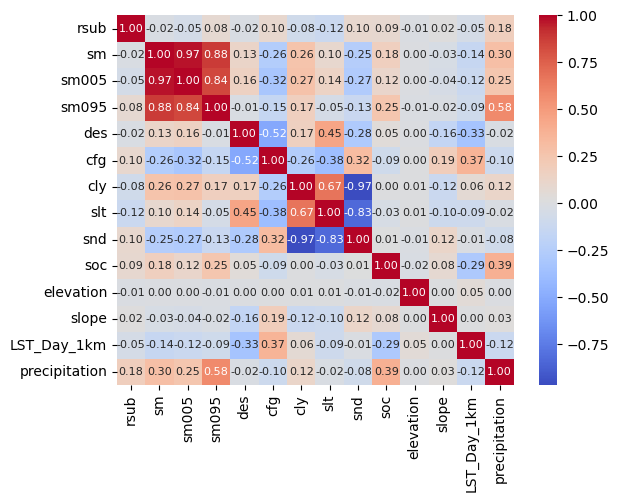

In [3]:
attributes = soil_df[['rsub', 'sm', 'sm005', 'sm095', 'des', 'cfg', 'cly', 'slt', 'snd', 'soc', 'elevation', 'slope', 'LST_Day_1km', 'precipitation']]
corr_matrix = attributes.corr().compute()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='coolwarm')
plt.show()

Unsurprisingly high correlation between soil moisture attributes and soil composition attributes. Everything else looks fine.

## Data Preprocessing

#### Depth
The values of the soil depth dimension are as follows:

- 0: 0--5 cm depth
- 1: 5--30 cm depth

We will only use the upper depth interval  (0--5 cm) of the soil properties. We therefore filter our Dask Dataframe, as follows:

In [28]:
soil_df = soil_df[soil_df.depth == "000_005"] 
soil_df

,x,y,depth,rsub,sm,sm005,sm095,des,cfg,cly,slt,snd,soc,tile,elevation,slope,LST_Day_1km,precipitation
npartitions=3,,,,,,,,,,,,,,,,,,
,float64,float64,string,float32,float32,float32,float32,float32,int8,int8,int8,int8,int8,string,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


#### Coarse Fragments
The variable coarse fragments has six ordinal categories:

1. very few (0-2%)
2. few (2-10%)
3. common (10-20%)
4. many (20-50%)
5. abundant (50-90%)
6. very abundant (>90%)

In [7]:
value_counts_percent = (soil_df["cfg"].value_counts(normalize=True).compute() * 100)
value_counts_percent.sort_index()

cfg
1    53.863841
2    13.899851
3     6.019366
4    25.365435
5     0.851507
Name: proportion, dtype: float64

As the fifth category of `cfg` only accounts for <1% of the observations and the sixth category is not present in the data, this is reduced to four categories:

In [9]:
CFG_CATS = dict(
    zip(range(1, 5), 
        ["very few (0-2%)", "few (2-10%)", "common (10-20%)", "many (>20%)"]
        ))
CFG_CATS

{1: 'very few (0-2%)',
 2: 'few (2-10%)',
 3: 'common (10-20%)',
 4: 'many (>20%)'}

In [11]:
soil_df['cfg'] = soil_df['cfg'].mask(soil_df['cfg'] == 5, 4)
soil_df = soil_df.persist()

value_counts_percent = (soil_df["cfg"].value_counts(normalize=True).compute() * 100)
value_counts_percent.sort_index()

cfg
1    53.863841
2    13.899851
3     6.019366
4    26.216942
Name: proportion, dtype: float64

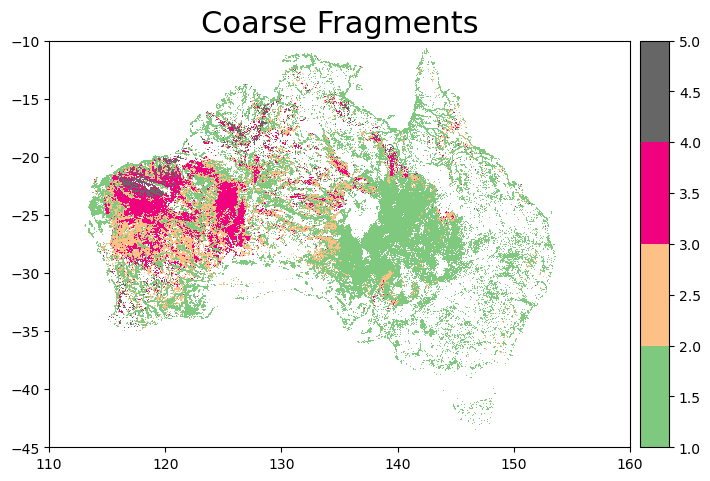

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
art0 = dsshow(soil_df, ds.Point('x', 'y'), ds.mean("cfg"), cmap=plt.get_cmap("Accent", 4), 
              x_range=[110, 160], y_range=[-45, -10], ax=ax)
ax.set_title("Coarse Fragments", fontsize=22)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(art0, cax=cax)
plt.show()

To include the `cfg` categories in the model we need to encode them, by transforming each category in each their own column with boolean values for when the category is present.
We first merge the categories to four levels with the 'Categorizer' and then use the 'DummyEncoder' to split it into multiple columns:

In [12]:
ca = Categorizer(categories={
    "cfg": CategoricalDtype(list(range(1,5)))
    })
de = DummyEncoder(["cfg"], drop_first=True)
soil_df = ca.fit_transform(soil_df)
soil_df = de.fit_transform(soil_df)
soil_df

,x,y,depth,rsub,sm,sm005,sm095,des,cly,slt,snd,soc,tile,elevation,slope,LST_Day_1km,precipitation,cfg_2,cfg_3,cfg_4
npartitions=3,,,,,,,,,,,,,,,,,,,,
,float64,float64,string,float32,float32,float32,float32,float32,int8,int8,int8,int8,string,float32,float32,float32,float32,bool,bool,bool
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


#### Elevation
As we saw earlier there are unexpected low values in the column `elevation`. We will take a close look to decide on how to proceed with them.

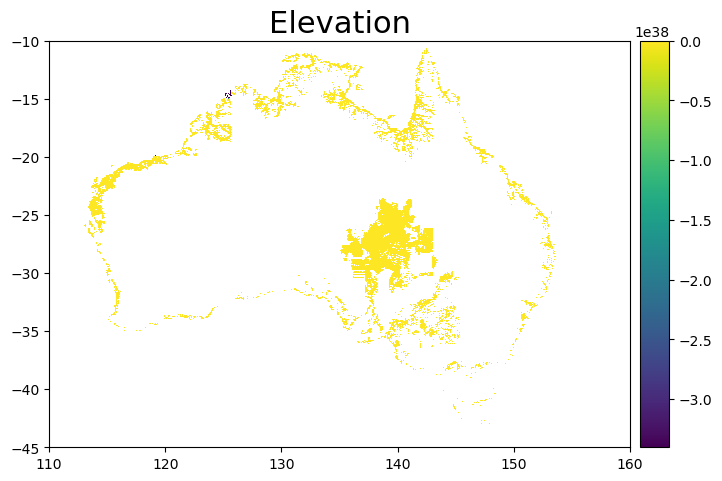

In [13]:
negative_elevation = soil_df[soil_df['elevation'] < 100].compute()


fig, ax = plt.subplots(figsize=(8, 8))
art0 = dsshow(negative_elevation, ds.Point('x', 'y'), ds.mean("elevation"), cmap="viridis", 
              x_range=[110, 160], y_range=[-45, -10], ax=ax)
ax.set_title("Elevation", fontsize=22)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(art0, cax=cax)
plt.show()

It looks like there is only a very small area affected by extreme values, which would probably heavily influence the analysis. Therefore, we decide to drop those extreme low values.

In [14]:
soil_df = soil_df[soil_df['elevation'] > -10000]
soil_df.describe().compute()

,x,y,rsub,sm,sm005,sm095,des,cly,slt,snd,soc,elevation,slope,LST_Day_1km,precipitation
count,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06,7.941255e+06
mean,1.280082e+02,-2.525581e+01,1.919499e-01,5.966114e-02,4.263685e-02,1.304541e-01,8.128927e-01,1.774056e+01,1.024445e+01,7.202052e+01,4.368126e-02,2.843131e+02,4.130154e-01,3.447451e+01,3.513616e+00
std,8.911425e+00,3.555695e+00,1.403104e-01,4.561715e-02,4.504954e-02,6.386323e-02,5.972864e-01,6.950481e+00,3.300187e+00,9.590019e+00,2.233806e-01,1.815829e+02,8.331764e-01,3.736387e+00,2.691470e+00
min,1.130947e+02,-4.350491e+01,1.000000e-04,9.994503e-03,1.104665e-05,9.994819e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.865930e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.192308e+02,-2.614009e+01,9.450000e-02,2.957656e-02,1.490566e-02,9.764877e-02,4.600000e-01,1.400000e+01,9.000000e+00,7.000000e+01,0.000000e+00,1.660632e+02,6.541112e-02,3.369547e+01,2.380172e+00
50%,1.260290e+02,-2.459588e+01,1.900000e-01,5.137173e-02,3.941225e-02,1.169330e-01,7.100000e-01,1.600000e+01,1.000000e+01,7.500000e+01,0.000000e+00,3.620622e+02,2.310325e-01,3.548966e+01,2.924054e+00
75%,1.366040e+02,-2.266515e+01,3.042000e-01,1.371900e-01,1.238739e-01,2.069488e-01,1.350000e+00,2.800000e+01,1.400000e+01,8.000000e+01,0.000000e+00,4.693411e+02,5.348556e-01,3.702852e+01,4.390877e+00
max,1.535927e+02,-1.070135e+01,8.835000e-01,4.632420e-01,3.554667e-01,5.607129e-01,2.300000e+00,6.000000e+01,3.000000e+01,9.700000e+01,7.000000e+00,1.401236e+03,2.624990e+01,4.286939e+01,5.174695e+01


Now, it seems that all data attributes are within a reasonable range and we will start with a visual exploration of the data.

### Data Visualization

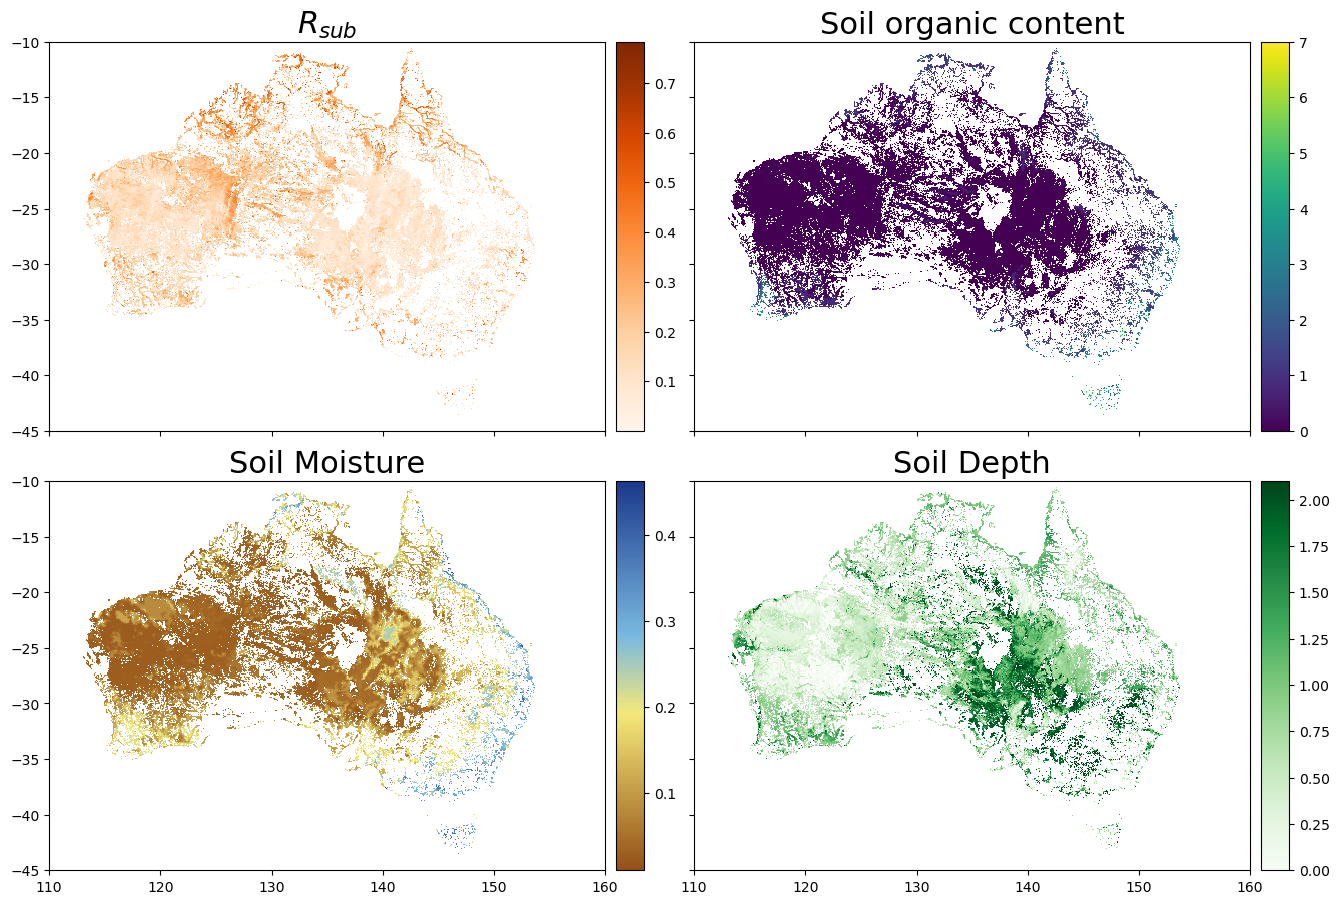

In [15]:
fig = plt.figure(figsize=(16, 16))

def load_cmap(file: Path) -> LinearSegmentedColormap:
    def to_hex_str(c_str: str) -> str:
        r_s, g_s, b_s = c_str.split()
        return f"#{int(r_s):02x}{int(g_s):02x}{int(b_s):02x}"

    ct_lines = Path(file).expanduser().read_text().splitlines()
    brn_yl_bu_colors = [to_hex_str(clr_str) for clr_str in ct_lines[:200]]
    return matplotlib.colors.LinearSegmentedColormap.from_list("", brn_yl_bu_colors)

SSM_CMAP = load_cmap("~/shared/datasets/rs/colour-tables/ssm-continuous.ct")

grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.5, share_all=True,
                 cbar_location="right", cbar_mode="each", cbar_size="5%", cbar_pad="2%")

art0 = dsshow(soil_df, ds.Point('x', 'y'), ds.mean("rsub"), cmap="Oranges", x_range=[110,160], y_range=[-45,-10], ax=grid[0])
grid[0].set_title("$R_{sub}$", fontsize=22)
plt.colorbar(art0, cax=grid.cbar_axes[0])

art1 = dsshow(soil_df, ds.Point('x', 'y'), ds.mean("soc"), cmap="viridis", x_range=[110,160], y_range=[-45,-10], ax=grid[1])
grid[1].set_title("Soil organic content", fontsize=22)
plt.colorbar(art1, cax=grid.cbar_axes[1])

art2 = dsshow(soil_df, ds.Point('x', 'y'), ds.mean("sm"), cmap=SSM_CMAP, x_range=[110,160], y_range=[-45,-10], ax=grid[2])
grid[2].set_title("Soil Moisture", fontsize=22)
plt.colorbar(art2, cax=grid.cbar_axes[2])

art3 = dsshow(soil_df, ds.Point('x', 'y'), ds.mean("des"), cmap="Greens", x_range=[110,160], y_range=[-45,-10], ax=grid[3])
grid[3].set_title("Soil Depth", fontsize=22)
plt.colorbar(art3, cax=grid.cbar_axes[3])

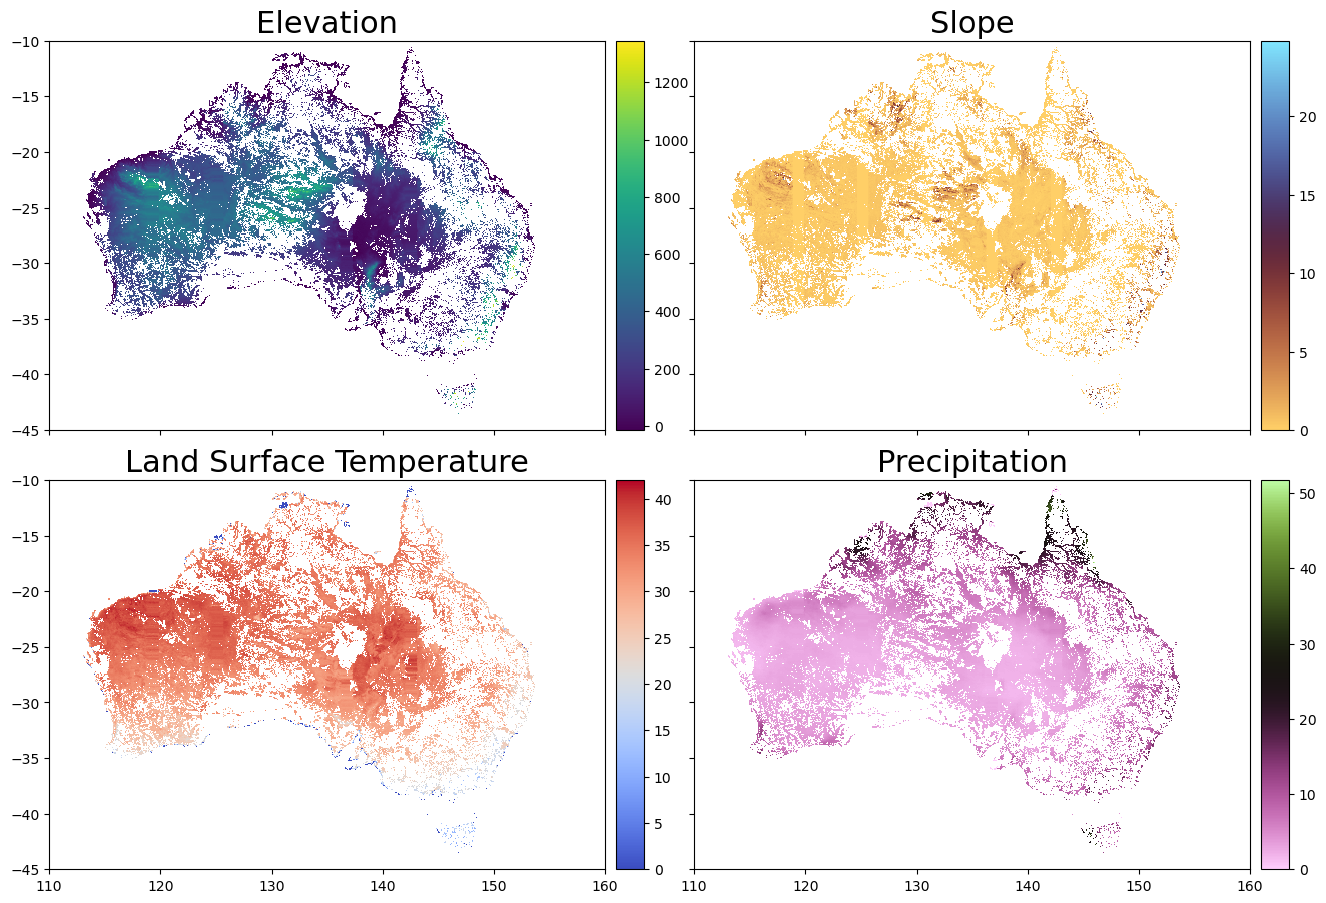

In [16]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.5, share_all=True,
                 cbar_location="right", cbar_mode="each", cbar_size="5%", cbar_pad="2%")

art0 = dsshow(soil_df, ds.Point('x', 'y'), ds.mean("elevation"), cmap="viridis", x_range=[110,160], y_range=[-45,-10], ax=grid[0])
grid[0].set_title("Elevation", fontsize=22)
plt.colorbar(art0, cax=grid.cbar_axes[0])

art1 = dsshow(soil_df, ds.Point('x', 'y'), ds.mean("slope"), cmap="managua", x_range=[110,160], y_range=[-45,-10], ax=grid[1])
grid[1].set_title("Slope", fontsize=22)
plt.colorbar(art1, cax=grid.cbar_axes[1])

art2 = dsshow(soil_df, ds.Point('x', 'y'), ds.mean("LST_Day_1km"), cmap="coolwarm", x_range=[110,160], y_range=[-45,-10], ax=grid[2])
grid[2].set_title("Land Surface Temperature", fontsize=22)
plt.colorbar(art2, cax=grid.cbar_axes[2])

art3 = dsshow(soil_df, ds.Point('x', 'y'), ds.mean("precipitation"), cmap="vanimo", x_range=[110,160], y_range=[-45,-10], ax=grid[3])
grid[3].set_title("Precipitation", fontsize=22)
plt.colorbar(art3, cax=grid.cbar_axes[3])

fig.savefig('add_data.png')

In [17]:
soil_df.to_parquet('preprocessed/', write_index=False)

## Modelling Pipeline

In [2]:
def model_comparison(model_mapping, EXP_VARIABLES, POLY_VARIABLES,
                     scaling=True, cv=5, fraction=1, 
                     polynomial_features=False):
    
    sampled_df = soil_df.sample(frac=fraction, random_state=11902046).compute()
    X = sampled_df[EXP_VARIABLES]
    y = sampled_df['rsub']
    
    if scaling:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    if polynomial_features:
        poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
        X = poly.fit_transform(X)
        EXP_VARIABLES = poly.get_feature_names_out(input_features=EXP_VARIABLES)
        
        if POLY_VARIABLES:
            selected_indices = [np.where(EXP_VARIABLES == feature)[0][0] for feature in POLY_VARIABLES]
            X = X[:, selected_indices]
            EXP_VARIABLES = POLY_VARIABLES
            print(f"Applied PolynomialFeatures with degree=2. Using {X.shape[1]} selected features.")
        else:
            print(f"Applied PolynomialFeatures with degree=2. New number of features: {X.shape[1]}")
    
    results_list = []
    feature_importance_dict = {}
    time_total = time.time()
    
    print(f"Starting cross-validation.")
    for model_name, model in model_mapping.items():
        start = time.time()
        
        scoring = {
            'rmse': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False),
            'r2': make_scorer(r2_score)
        }
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=True)
        
        mean_rmse, std_rmse = -cv_results['test_rmse'].mean(), cv_results['test_rmse'].std()
        mean_r2, std_r2 = cv_results['test_r2'].mean(), cv_results['test_r2'].std()
        mean_train_rmse = -cv_results['train_rmse'].mean()
        mean_train_r2 = cv_results['train_r2'].mean()
        
        results_list.append({
            'model': model_name,
            'mean_rmse': round(mean_rmse, 3),
            'std_rmse': round(std_rmse, 3),
            'mean_r2': round(mean_r2, 3),
            'std_r2': round(std_r2, 3),
            'mean_train_rmse': round(mean_train_rmse, 3),
            'mean_train_r2': round(mean_train_r2, 3)
        })
        
        coefs = []
        for estimator in cv_results['estimator']:
            if hasattr(estimator, 'feature_importances_'):  # Random Forest, XGBoost, etc.
                coefs.append(estimator.feature_importances_)
            elif hasattr(estimator, 'coef_'):  # Linear models
                coefs.append(estimator.coef_.flatten() if model_name == 'pls' else estimator.coef_)
        
        if coefs:
            mean_coefs = np.mean(coefs, axis=0)
            feature_importance_dict[model_name] = {var: round(mean_coefs[i], 4) for i, var in enumerate(EXP_VARIABLES)}
        else:
            print(f"{model_name} does not provide feature importance or coefficients.")
        
        print(f"{model_name} model completed in {round(time.time()-start, 0)}s")
    
    results_df = pd.DataFrame(results_list)
    feature_importance_df = pd.DataFrame(feature_importance_dict)
    print(f"Total time: {round(time.time()-time_total, 0)}s")
    
    display(results_df)
    return feature_importance_df

def display_top_features(feature_importance_df, model, top_k):
    if model and model in feature_importance_df.columns:
        top_features = feature_importance_df[model].abs().nlargest(top_k).index
        feature_importance_df = feature_importance_df.loc[top_features]
        display(feature_importance_df)
        display(feature_importance_df.T.columns)
    else:
        print(f"{model} not found in feature importance dataframe.")

In [3]:
soil_df = dd.read_parquet("preprocessed/")
soil_df.columns

Index(['x', 'y', 'depth', 'rsub', 'sm', 'sm005', 'sm095', 'des', 'cly', 'slt',
       'snd', 'soc', 'tile', 'elevation', 'slope', 'LST_Day_1km',
       'precipitation', 'cfg_2', 'cfg_3', 'cfg_4'],
      dtype='object')

### Baseline

In [4]:
EXP_VARIABLES = ['sm', 'sm005', 'sm095', 'des', 'cly', 'slt', 'snd', 'soc', 'elevation', 'slope', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4']
POLY_VARIABLES = []

model_mapping = {
    'linear': SGDRegressor(fit_intercept=False),
    'pls': PLSRegression(n_components=len(EXP_VARIABLES)),
    'ridge': Ridge(fit_intercept=False, alpha=0.1),
    'elastic_net': ElasticNet(alpha=0.005, l1_ratio=0.6, fit_intercept=False),
    'lasso': Lasso(alpha=0.005, fit_intercept=False),
}

feature_importance_df = model_comparison(model_mapping, EXP_VARIABLES, POLY_VARIABLES,
                                         scaling=True, cv=3, fraction=0.4,
                                         polynomial_features=False)

Starting cross-validation.
linear model completed in 9.0s
pls model completed in 28.0s
ridge model completed in 1.0s
elastic_net model completed in 123.0s
lasso model completed in 56.0s
Total time: 217.0s


,model,mean_rmse,std_rmse,mean_r2,std_r2,mean_train_rmse,mean_train_r2
0,linear,0.280,0.014,-3.054,0.485,0.226,-1.603
1,pls,0.150,0.011,-0.156,0.173,0.133,0.102
2,ridge,0.282,0.016,-3.112,0.546,0.226,-1.599
3,elastic_net,0.268,0.009,-2.707,0.308,0.227,-1.632
4,lasso,0.263,0.005,-2.546,0.211,0.228,-1.655


In [5]:
display_top_features(feature_importance_df, 'pls', 15)

,linear,pls,ridge,elastic_net,lasso
sm005,-0.0610,-0.0413,-0.0612,-0.0209,-0.0179
cly,0.0154,0.0396,0.0143,-0.0081,-0.0035
snd,0.0281,0.0308,0.0298,0.0006,0.0051
sm095,0.0403,0.0230,0.0394,0.0227,0.0208
sm,0.0090,0.0215,0.0073,-0.0158,-0.0142
slt,0.0025,-0.0152,0.0012,-0.0099,-0.0092
cfg_4,0.0138,0.0138,0.0162,0.0137,0.0116
precipitation,0.0113,0.0116,0.0112,0.0186,0.0165
des,0.0084,0.0094,0.0092,0.0098,0.0106
elevation,-0.0070,-0.0078,-0.0085,-0.0033,-0.0021


Index(['sm005', 'cly', 'snd', 'sm095', 'sm', 'slt', 'cfg_4', 'precipitation',
       'des', 'elevation', 'LST_Day_1km', 'cfg_2', 'slope', 'cfg_3', 'soc'],
      dtype='object')

R2 highly negative, RMSE very high.

### Model & Variable Selection
Goal: Subsequently reduce feature space and increase fraction of data

In [6]:
EXP_VARIABLES = ['sm', 'sm005', 'sm095', 'des', 'cly', 'slt', 'snd', 'soc', 'elevation', 'slope', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4']
POLY_VARIABLES = []

model_mapping = {
    #'linear': SGDRegressor(fit_intercept=False),
    'pls': PLSRegression(n_components=len(EXP_VARIABLES)),
    'ridge': Ridge(fit_intercept=False, alpha=0.1),
    'elastic_net': ElasticNet(alpha=0.005, l1_ratio=0.6, fit_intercept=False),
    'lasso': Lasso(alpha=0.005, fit_intercept=False),
}

feature_importance_df = model_comparison(model_mapping, EXP_VARIABLES, POLY_VARIABLES,
                                         scaling=True, cv=2, fraction=0.1,
                                         polynomial_features=True)

Applied PolynomialFeatures with degree=2. New number of features: 120
Starting cross-validation.
pls model completed in 23.0s
ridge model completed in 17.0s
elastic_net model completed in 932.0s
lasso model completed in 517.0s
Total time: 1490.0s


,model,mean_rmse,std_rmse,mean_r2,std_r2,mean_train_rmse,mean_train_r2
0,pls,0.156,0.005,-0.244,0.041,0.126,0.193
1,ridge,0.156,0.009,-0.236,0.097,0.125,0.204
2,elastic_net,0.166,0.001,-0.398,0.036,0.138,0.026
3,lasso,0.177,0.002,-0.597,0.007,0.146,-0.092


In [7]:
display_top_features(feature_importance_df, 'elastic_net', 20)

,pls,ridge,elastic_net,lasso
cfg_2 cfg_4,-0.0051,-0.5306,-0.1805,-0.0473
cfg_4,0.0109,-0.2872,-0.1343,-0.0801
cfg_2,-0.0036,-0.3627,-0.0941,-0.0081
elevation cfg_4,0.0077,0.0105,0.0557,0.0647
slt cfg_4,-0.0174,-0.0166,-0.0469,-0.0367
LST_Day_1km cfg_4,-0.0085,-0.0103,0.0424,0.0461
slt,-0.0275,-0.0278,-0.0388,-0.0332
LST_Day_1km,-0.0019,-0.0028,0.0207,0.0197
sm005 cfg_4,-0.0114,-0.0530,-0.0206,-0.0192
cly snd,0.0086,0.0043,-0.0197,-0.0250


Index(['cfg_2 cfg_4', 'cfg_4', 'cfg_2', 'elevation cfg_4', 'slt cfg_4',
       'LST_Day_1km cfg_4', 'slt', 'LST_Day_1km', 'sm005 cfg_4', 'cly snd',
       'des cfg_4', 'sm005', 'elevation cfg_2', 'sm', 'sm095 precipitation',
       'des LST_Day_1km', 'elevation', 'cfg_3 cfg_4', 'sm sm005',
       'elevation cfg_3'],
      dtype='object')

In [10]:
EXP_VARIABLES = ['sm', 'sm005', 'sm095', 'des', 'cly', 'slt', 'snd', 'soc', 'elevation', 'slope', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4']
POLY_VARIABLES = ['cfg_2 cfg_4', 'cfg_4', 'cfg_2', 'elevation cfg_4', 'slt cfg_4',
       'LST_Day_1km cfg_4', 'slt', 'LST_Day_1km', 'sm005 cfg_4', 'cly snd',
       'des cfg_4', 'sm005', 'elevation cfg_2', 'sm', 'sm095 precipitation',
       'des LST_Day_1km', 'elevation', 'cfg_3 cfg_4', 'sm sm005',
       'elevation cfg_3']

model_mapping = {
    'linear': SGDRegressor(fit_intercept=False),
    'pls': PLSRegression(n_components=len(EXP_VARIABLES)),
    'ridge': Ridge(fit_intercept=False, alpha=0.1),
    'elastic_net': ElasticNet(alpha=0.005, l1_ratio=0.6, fit_intercept=False),
    'lasso': Lasso(alpha=0.005, fit_intercept=False),
}

feature_importance_df = model_comparison(model_mapping, EXP_VARIABLES, POLY_VARIABLES,
                                         scaling=True, cv=3, fraction=0.3,
                                         polynomial_features=True)

Applied PolynomialFeatures with degree=2. Using 20 selected features.
Starting cross-validation.
linear model completed in 7.0s
elastic_net model completed in 369.0s
lasso model completed in 383.0s
Total time: 786.0s


,model,mean_rmse,std_rmse,mean_r2,std_r2,mean_train_rmse,mean_train_r2
0,linear,0.142,0.002,-0.035,0.064,0.133,0.093
1,pls,0.142,0.002,-0.040,0.067,0.133,0.098
2,ridge,0.142,0.002,-0.040,0.067,0.133,0.098
3,elastic_net,0.153,0.003,-0.210,0.087,0.142,-0.022
4,lasso,0.163,0.005,-0.373,0.129,0.149,-0.127


In [12]:
display_top_features(feature_importance_df, 'elastic_net', 10)

,linear,pls,ridge,elastic_net,lasso
cfg_2 cfg_4,-0.7671,0.0028,-0.7678,-0.2686,-0.1180
cfg_4,-0.3003,0.0083,-0.3003,-0.1723,-0.1193
cfg_2,-0.4662,-0.0074,-0.4665,-0.1518,-0.0543
slt cfg_4,-0.0230,-0.0240,-0.0232,-0.0587,-0.0586
slt,-0.0259,-0.0261,-0.0256,-0.0519,-0.0527
elevation cfg_4,0.0008,0.0012,0.0010,0.0440,0.0563
LST_Day_1km cfg_4,-0.0067,-0.0065,-0.0069,0.0362,0.0443
sm005 cfg_4,-0.0148,-0.0151,-0.0151,-0.0295,-0.0310
sm,0.0459,0.0465,0.0468,-0.0174,-0.0277
sm005,-0.0540,-0.0534,-0.0537,-0.0170,-0.0141


Index(['cfg_2 cfg_4', 'cfg_4', 'cfg_2', 'slt cfg_4', 'slt', 'elevation cfg_4',
       'LST_Day_1km cfg_4', 'sm005 cfg_4', 'sm', 'sm005'],
      dtype='object')

In [16]:
EXP_VARIABLES = ['sm', 'sm005', 'sm095', 'des', 'cly', 'slt', 'snd', 'soc', 'elevation', 'slope', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4']
POLY_VARIABLES = ['cfg_2 cfg_4', 'cfg_4', 'cfg_2', 'slt cfg_4', 'slt', 'elevation cfg_4',
       'LST_Day_1km cfg_4', 'sm005 cfg_4', 'sm', 'sm005']

model_mapping = {
    'linear': SGDRegressor(fit_intercept=False),
    'pls': PLSRegression(n_components=len(POLY_VARIABLES)-1),
    'ridge': Ridge(fit_intercept=False, alpha=0.1),
    'elastic_net': ElasticNet(alpha=0.005, l1_ratio=0.6, fit_intercept=False),
    'lasso': Lasso(alpha=0.005, fit_intercept=False),
}

feature_importance_df = model_comparison(model_mapping, EXP_VARIABLES, POLY_VARIABLES,
                                         scaling=True, cv=3, fraction=0.5,
                                         polynomial_features=True)

Applied PolynomialFeatures with degree=2. Using 10 selected features.
Starting cross-validation.
linear model completed in 12.0s
pls model completed in 19.0s
ridge model completed in 1.0s
elastic_net model completed in 211.0s
lasso model completed in 234.0s
Total time: 477.0s


,model,mean_rmse,std_rmse,mean_r2,std_r2,mean_train_rmse,mean_train_r2
0,linear,0.143,0.003,-0.046,0.058,0.136,0.059
1,pls,0.142,0.002,-0.043,0.050,0.136,0.059
2,ridge,0.142,0.002,-0.043,0.050,0.136,0.059
3,elastic_net,0.147,0.005,-0.110,0.087,0.143,-0.035
4,lasso,0.151,0.008,-0.175,0.131,0.146,-0.092


In [18]:
display_top_features(feature_importance_df, 'elastic_net', 8)

,linear,pls,ridge,elastic_net,lasso
cfg_2 cfg_4,-0.7373,0.0116,-0.7379,-0.4243,-0.3653
cfg_2,-0.4453,0.0008,-0.4460,-0.2470,-0.2075
cfg_4,-0.3133,-0.0126,-0.3136,-0.2360,-0.2097
slt cfg_4,-0.0300,-0.0296,-0.0295,-0.0689,-0.0630
slt,-0.0294,-0.0297,-0.0297,-0.0515,-0.0457
sm005 cfg_4,-0.0139,-0.0126,-0.0126,-0.0380,-0.0369
LST_Day_1km cfg_4,0.0047,0.0071,0.0071,0.0376,0.0415
elevation cfg_4,0.0058,0.0060,0.0060,0.0339,0.0403


Index(['cfg_2 cfg_4', 'cfg_2', 'cfg_4', 'slt cfg_4', 'slt', 'sm005 cfg_4',
       'LST_Day_1km cfg_4', 'elevation cfg_4'],
      dtype='object')

Performance stagnating for all models.

### PLS: optimal number of components

In [4]:
EXP_VARIABLES = ['sm', 'sm005', 'sm095', 'des', 'cly', 'slt', 'snd', 'soc', 'elevation', 'slope', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4']
POLY_VARIABLES = ['cfg_2 cfg_4', 'cfg_2', 'cfg_4', 'slt cfg_4', 'slt', 'sm005 cfg_4', 'LST_Day_1km cfg_4', 'elevation cfg_4']

sampled_df = soil_df.sample(frac=1, random_state=11902046).compute()
X = sampled_df[EXP_VARIABLES]
y = sampled_df['rsub']

scaler = StandardScaler()
X = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X = poly.fit_transform(X)
EXP_VARIABLES = poly.get_feature_names_out(input_features=EXP_VARIABLES)

selected_indices = [np.where(EXP_VARIABLES == feature)[0][0] for feature in POLY_VARIABLES]
X = X[:, selected_indices]
EXP_VARIABLES = POLY_VARIABLES

Optimal number of components: 7


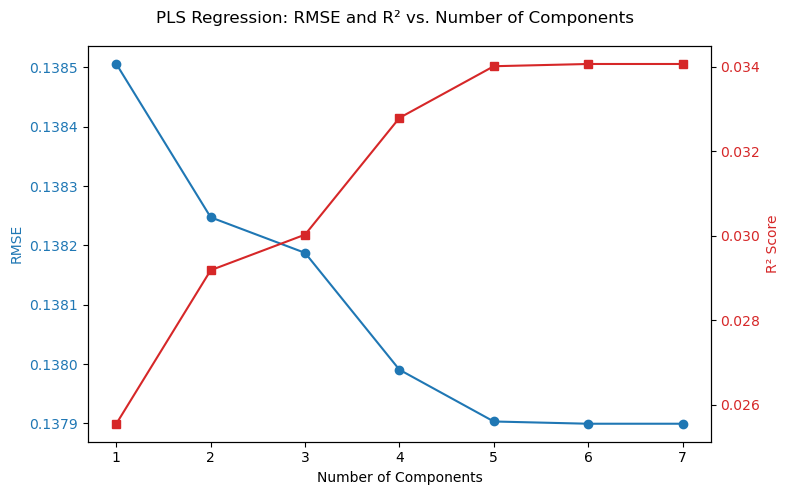

In [5]:
# Cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=11902046)
n_components_range = range(1, X.shape[1])
rmse_scores = []
r2_scores = []

for n in n_components_range:
    rmse_fold = []
    r2_fold = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = PLSRegression(n_components=n)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse_fold.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_fold.append(r2_score(y_test, y_pred))

    rmse_scores.append(np.mean(rmse_fold))
    r2_scores.append(np.mean(r2_fold))

optimal_n_components = n_components_range[np.argmin(rmse_scores)]
print(f"Optimal number of components: {optimal_n_components}")

# --- Plot RMSE and R² vs. Components ---
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_xlabel("Number of Components")
ax1.set_ylabel("RMSE", color="tab:blue")
ax1.plot(n_components_range, rmse_scores, marker="o", color="tab:blue", label="RMSE")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.set_ylabel("R² Score", color="tab:red")
ax2.plot(n_components_range, r2_scores, marker="s", color="tab:red", label="R² Score")
ax2.tick_params(axis="y", labelcolor="tab:red")
fig.suptitle("PLS Regression: RMSE and R² vs. Number of Components")
fig.tight_layout()
plt.savefig("PLS_components.png")
plt.show()

Final Model RMSE: 0.1379
Final Model R² Score: 0.0341


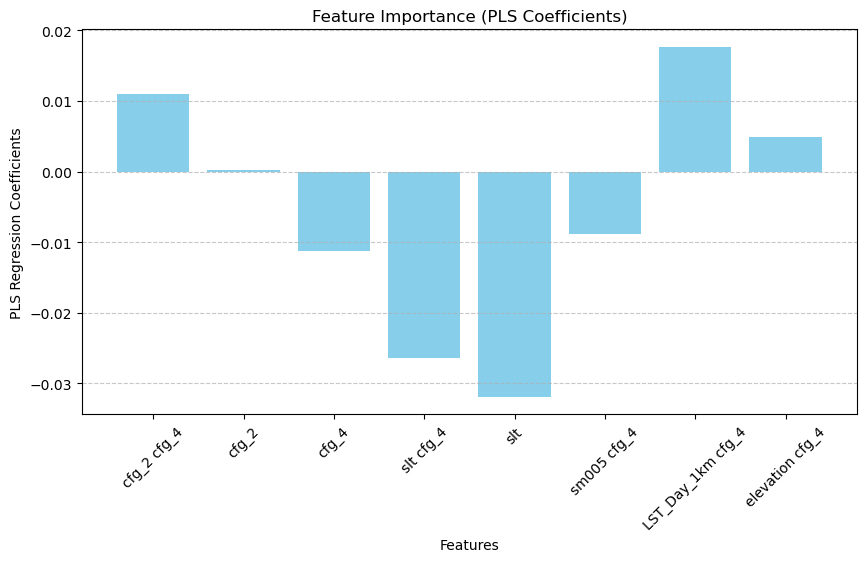

In [6]:
# optimal PLS model
model = PLSRegression(n_components=optimal_n_components)
model.fit(X, y)

y_pred = model.predict(X)
final_rmse = np.sqrt(mean_squared_error(y, y_pred))
final_r2 = r2_score(y, y_pred)
print(f"Final Model RMSE: {final_rmse:.4f}")
print(f"Final Model R² Score: {final_r2:.4f}")

# --- Feature Importance (Model Coefficients) ---
plt.figure(figsize=(10, 5))
plt.bar(EXP_VARIABLES, model.coef_.flatten(), color="skyblue")
plt.xlabel("Features")
plt.ylabel("PLS Regression Coefficients")
plt.title("Feature Importance (PLS Coefficients)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

No potential for improvement in n_components for `n > 5`, therefore `n = 5` is considered optimal.

### Non-Linear Methods

In [11]:
# Baseline
EXP_VARIABLES = ['sm', 'sm005', 'sm095', 'des', 'cly', 'slt', 'snd', 'soc', 'elevation', 'slope', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4']
POLY_VARIABLES = []

model_mapping = {
    'pls': PLSRegression(n_components=5),
    'elastic_net': ElasticNet(alpha=0.003, l1_ratio=0.7, fit_intercept=False),
    'random_forest': RandomForestRegressor(n_estimators=10, max_depth=10, random_state=11902046),
    'xgboost': XGBRegressor(n_estimators=20, random_state=11902046)
}

feature_importance_df = model_comparison(model_mapping, EXP_VARIABLES, POLY_VARIABLES,
                                         scaling=True, cv=2, fraction=0.3,
                                         polynomial_features=False)

Starting cross-validation.
pls model completed in 5.0s
elastic_net model completed in 347.0s
random_forest model completed in 120.0s
xgboost model completed in 28.0s
Total time: 500.0s


,model,mean_rmse,std_rmse,mean_r2,std_r2,mean_train_rmse,mean_train_r2
0,pls,0.155,0.005,-0.225,0.036,0.130,0.141
1,elastic_net,0.292,0.005,-3.351,0.019,0.211,-1.266
2,random_forest,0.143,0.010,-0.049,0.182,0.117,0.302
3,xgboost,0.141,0.007,-0.012,0.138,0.117,0.305


In [12]:
display_top_features(feature_importance_df, 'random_forest', 8)

,pls,elastic_net,random_forest,xgboost
elevation,-0.0018,-0.0045,0.3053,0.1584
precipitation,0.0179,0.0233,0.2373,0.1003
LST_Day_1km,-0.0087,-0.0026,0.1219,0.0764
sm095,0.0110,0.0146,0.0544,0.0405
des,0.0084,0.0114,0.0535,0.0509
sm005,-0.0092,-0.0128,0.0487,0.0389
slope,0.0030,0.0035,0.0469,0.0514
sm,0.0017,-0.0222,0.0439,0.0317


Index(['elevation', 'precipitation', 'LST_Day_1km', 'sm095', 'des', 'sm005',
       'slope', 'sm'],
      dtype='object')

In [13]:
EXP_VARIABLES = ['sm', 'sm005', 'des', 'slt', 'snd', 'elevation', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4']
POLY_VARIABLES = ['cfg_2 cfg_4', 'cfg_2', 'cfg_4', 'slt cfg_4', 'slt', 'sm005 cfg_4', 'LST_Day_1km cfg_4', 'elevation cfg_4']

model_mapping = {
    'pls': PLSRegression(n_components=5),
    'elastic_net': ElasticNet(alpha=0.003, l1_ratio=0.7, fit_intercept=False),
    'random_forest': RandomForestRegressor(n_estimators=10, max_depth=10, random_state=11902046),
    'xgboost': XGBRegressor(n_estimators=20, random_state=11902046)
}
feature_importance_df = model_comparison(model_mapping, EXP_VARIABLES, POLY_VARIABLES,
                                         scaling=True, cv=3, fraction=0.8,
                                         polynomial_features=True)

Applied PolynomialFeatures with degree=2. Using 8 selected features.
Starting cross-validation.
pls model completed in 13.0s
elastic_net model completed in 173.0s
random_forest model completed in 354.0s
xgboost model completed in 58.0s
Total time: 597.0s


,model,mean_rmse,std_rmse,mean_r2,std_r2,mean_train_rmse,mean_train_r2
0,pls,0.143,0.001,-0.057,0.043,0.137,0.045
1,elastic_net,0.145,0.003,-0.077,0.044,0.139,0.009
2,random_forest,0.130,0.003,0.134,0.046,0.124,0.221
3,xgboost,0.130,0.003,0.128,0.039,0.123,0.225


In [16]:
display_top_features(feature_importance_df, 'random_forest', 8)

,pls,elastic_net,random_forest,xgboost
elevation cfg_4,0.0031,0.0225,0.4587,0.2216
sm005 cfg_4,-0.0124,-0.0175,0.2241,0.0948
LST_Day_1km cfg_4,0.0161,0.0306,0.1675,0.1147
slt,-0.0282,-0.0421,0.0749,0.2386
slt cfg_4,-0.0231,-0.0510,0.0518,0.0776
cfg_2 cfg_4,0.0103,-0.5506,0.0157,0.2217
cfg_2,-0.0003,-0.3257,0.0055,0.0000
cfg_4,-0.0096,-0.2589,0.0018,0.0310


Index(['elevation cfg_4', 'sm005 cfg_4', 'LST_Day_1km cfg_4', 'slt',
       'slt cfg_4', 'cfg_2 cfg_4', 'cfg_2', 'cfg_4'],
      dtype='object')

In [7]:
EXP_VARIABLES = ['sm', 'sm005', 'des', 'slt', 'snd', 'elevation', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4']
POLY_VARIABLES = []

model_mapping = {
    'pls': PLSRegression(n_components=5),
    #'elastic_net': ElasticNet(alpha=0.003, l1_ratio=0.7, fit_intercept=False),
    'random_forest': RandomForestRegressor(n_estimators=10, max_depth=10, random_state=11902046),
    'xgboost': XGBRegressor(n_estimators=20, random_state=11902046)
}
feature_importance_df = model_comparison(model_mapping, EXP_VARIABLES, POLY_VARIABLES,
                                         scaling=True, cv=3, fraction=0.8,
                                         polynomial_features=True)

Applied PolynomialFeatures with degree=2. New number of features: 66
Starting cross-validation.
pls model completed in 39.0s
random_forest model completed in 4373.0s
xgboost model completed in 69.0s
Total time: 4481.0s


,model,mean_rmse,std_rmse,mean_r2,std_r2,mean_train_rmse,mean_train_r2
0,pls,0.144,0.005,-0.069,0.093,0.132,0.119
1,random_forest,0.127,0.005,0.178,0.062,0.119,0.279
2,xgboost,0.125,0.003,0.203,0.040,0.118,0.286


In [8]:
display_top_features(feature_importance_df, 'random_forest', 15)

,pls,random_forest,xgboost
elevation,-0.0032,0.1868,0.0868
precipitation,0.0197,0.0975,0.0513
elevation cfg_4,0.0058,0.0595,0.0317
sm005 LST_Day_1km,-0.0027,0.0499,0.0244
sm005,-0.0076,0.0391,0.0222
LST_Day_1km cfg_4,0.0027,0.0378,0.0476
precipitation cfg_4,-0.0091,0.0328,0.0292
des precipitation,-0.0097,0.0261,0.0189
sm cfg_2,0.0012,0.0254,0.0289
des cfg_2,0.0015,0.0249,0.0534


Index(['elevation', 'precipitation', 'elevation cfg_4', 'sm005 LST_Day_1km',
       'sm005', 'LST_Day_1km cfg_4', 'precipitation cfg_4',
       'des precipitation', 'sm cfg_2', 'des cfg_2', 'sm005 precipitation',
       'des cfg_4', 'elevation precipitation', 'sm', 'sm005 elevation'],
      dtype='object')

### Explainability

In [60]:
from lime.lime_tabular import LimeTabularExplainer

def fit_model(model, EXP_VARIABLES, POLY_VARIABLES):
    soil_df_full = soil_df.compute()
    X = soil_df_full[EXP_VARIABLES]
    y = soil_df_full['rsub']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
    X = poly.fit_transform(X)
    EXP_VARIABLES = poly.get_feature_names_out(input_features=EXP_VARIABLES)
    selected_indices = [i for i, feature in enumerate(EXP_VARIABLES) if feature in POLY_VARIABLES]
    X = X[:, selected_indices]
    EXP_VARIABLES = POLY_VARIABLES
    print(f"Applied PolynomialFeatures with degree=2. Using {X.shape[1]} selected features.")

    model.fit(X, y)
    rsub_pred = model.predict(X)
    soil_df_full['rsub_pred'] = rsub_pred
    soil_df_full['rsub_diff'] = soil_df_full['rsub'] - soil_df_full['rsub_pred']

    rmse = np.sqrt(mean_squared_error(y, rsub_pred))
    r2 = r2_score(y, rsub_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    model_coefficients = []
    if hasattr(model, 'feature_importances_'):
        model_coefficients = model.feature_importances_
    elif hasattr(model, 'coef_'):
        model_coefficients = model.coef_.flatten() if model_name == 'PLS' else model.coef_
    coeff_df = pd.DataFrame({'Feature': EXP_VARIABLES, 'Coefficient': model_coefficients})
    display(coeff_df.reindex(coeff_df['Coefficient'].abs().sort_values(ascending=False).index).reset_index(drop=True))

    return model, X, EXP_VARIABLES

def explain_model(model, X, EXP_VARIABLES):
    explainer = LimeTabularExplainer(X, feature_names=EXP_VARIABLES, class_names=['rsub'], verbose=True, mode='regression')
    i = np.random.randint(0, X.shape[0])
    exp = explainer.explain_instance(X[i], model.predict, num_features=8)
    for condition in exp.as_list():
        print(condition)

In [52]:
model, X, vars = fit_model(model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=11902046),
                           EXP_VARIABLES = ['sm', 'sm005', 'sm095', 'des', 'cly', 'slt', 'snd', 'soc', 'elevation', 'slope', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4'],
                           POLY_VARIABLES = ['cfg_2 cfg_4', 'cfg_2', 'cfg_4', 'slt cfg_4', 'slt', 'sm005 cfg_4', 'LST_Day_1km cfg_4', 'elevation cfg_4'])

Applied PolynomialFeatures with degree=2. Using 8 selected features.
RMSE: 0.1234
R² Score: 0.2264


,Feature,Coefficient
0,sm005 cfg_4,0.461373
1,slt cfg_4,0.221604
2,LST_Day_1km cfg_4,0.170485
3,cfg_2 cfg_4,0.088461
4,slt,0.036710
5,elevation cfg_4,0.014879
6,cfg_2,0.005236
7,cfg_4,0.001252


In [61]:
explain_model(model, X, vars)

Intercept 0.16880378148875358
Prediction_local [0.2437423]
Right: 0.2863165969859903
('slt cfg_4 <= -0.96', 0.03567854035781158)
('LST_Day_1km cfg_4 > 0.81', 0.012128562151607899)
('sm005 cfg_4 > 0.92', 0.01178229185323105)
('-0.68 < cfg_2 cfg_4 <= -0.38', 0.00812911830902262)
('-0.60 < cfg_4 <= 1.68', 0.007434051859076725)
('slt <= -0.63', 0.00269356629066201)
('elevation cfg_4 <= -0.67', -0.0023432643609655793)
('cfg_2 <= -0.40', -0.0005643500929494867)


In [62]:
explain_model(model, X, vars)

Intercept 0.18662871156829886
Prediction_local [0.19491543]
Right: 0.1536134325979846
('cfg_2 cfg_4 <= -0.68', 0.02175625674294196)
('LST_Day_1km cfg_4 <= -0.24', -0.010275533396725971)
('sm005 cfg_4 <= -0.22', 0.006919525776574919)
('-0.96 < slt cfg_4 <= -0.13', -0.006715543010821186)
('cfg_4 <= -0.60', -0.006432610578918962)
('-0.67 < elevation cfg_4 <= 0.24', 0.00251902188442194)
('slt > 0.22', 0.0023285231701848648)
('cfg_2 <= -0.40', -0.0018129242428477363)


In [63]:
explain_model(model, X, vars)

Intercept 0.17341586327433053
Prediction_local [0.2342689]
Right: 0.1879049479467642
('slt cfg_4 <= -0.96', 0.03454442747976332)
('sm005 cfg_4 > 0.92', 0.015218910291954416)
('-0.68 < cfg_2 cfg_4 <= -0.38', 0.007195705546168034)
('elevation cfg_4 <= -0.67', -0.0049648711636749165)
('-0.60 < cfg_4 <= 1.68', 0.004161843093995753)
('0.20 < LST_Day_1km cfg_4 <= 0.81', 0.0029428261434286947)
('slt <= -0.63', 0.0026272530268949246)
('cfg_2 <= -0.40', -0.0008730532646437892)


In [64]:
explain_model(model, X, vars)

Intercept 0.19329755335953
Prediction_local [0.17753732]
Right: 0.1342782918760173
('slt cfg_4 > 0.29', -0.015708012315688125)
('-0.24 < LST_Day_1km cfg_4 <= 0.20', -0.006016466907137691)
('cfg_4 <= -0.60', -0.005812192752097236)
('sm005 cfg_4 <= -0.22', 0.005787387218966594)
('-0.68 < cfg_2 cfg_4 <= -0.38', 0.004821075573479388)
('-0.67 < elevation cfg_4 <= 0.24', 0.0037537665392510275)
('-0.14 < slt <= 0.22', -0.0016559689063203784)
('cfg_2 <= -0.40', -0.0009298198221077346)


In [65]:
explain_model(model, X, vars)

Intercept 0.18742868554163072
Prediction_local [0.19762834]
Right: 0.1722933403527302
('slt cfg_4 <= -0.96', 0.03177878377429611)
('cfg_2 cfg_4 > 0.53', -0.01928679216606693)
('-0.22 < sm005 cfg_4 <= 0.51', -0.014037788047417357)
('LST_Day_1km cfg_4 > 0.81', 0.013441591044576545)
('cfg_4 <= -0.60', -0.007250182052350532)
('slt <= -0.63', 0.00425091837794572)
('-0.67 < elevation cfg_4 <= 0.24', 0.002738648472103212)
('cfg_2 <= -0.40', -0.0014355250435951724)


## Evaluation (final model)

In [69]:
def evaluate_model(model, model_name=None, POLY_VARIABLES=None, EXP_VARIABLES=None, deviation_threshold=0, var_of_interest=""):

    if not EXP_VARIABLES:
        EXP_VARIABLES = ['sm', 'sm005', 'sm095', 'des', 'cly', 'slt', 'snd', 'soc', 'elevation', 'slope', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4']

    soil_df_full = soil_df.compute()
    X = soil_df_full[EXP_VARIABLES]
    y = soil_df_full['rsub']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if POLY_VARIABLES:
        if len(POLY_VARIABLES) == 1:
            var_of_interest = POLY_VARIABLES[0]
            POLY_VARIABLES += [f"{var} {var_of_interest}" for var in EXP_VARIABLES if var != var_of_interest]
        elif not var_of_interest:
            var_of_interest = "rsub"

        poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
        X = poly.fit_transform(X)
        EXP_VARIABLES = poly.get_feature_names_out(input_features=EXP_VARIABLES)
        
        selected_indices = [i for i, feature in enumerate(EXP_VARIABLES) if feature in POLY_VARIABLES]
        if not selected_indices:
            raise ValueError(f"No interaction terms found for variable_of_interest: {var_of_interest}")

        X = X[:, selected_indices]
        EXP_VARIABLES = POLY_VARIABLES
        print(f"Applied PolynomialFeatures with degree=2. Using {X.shape[1]} selected features.")
    elif not var_of_interest:
        var_of_interest = "rsub"

    model.fit(X, y)
    rsub_pred = model.predict(X)
    soil_df_full['rsub_pred'] = rsub_pred
    soil_df_full['rsub_diff'] = soil_df_full['rsub'] - soil_df_full['rsub_pred']

    rmse = np.sqrt(mean_squared_error(y, rsub_pred))
    r2 = r2_score(y, rsub_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    model_coefficients = []
    if hasattr(model, 'feature_importances_'):
        model_coefficients = model.feature_importances_
    elif hasattr(model, 'coef_'):
        model_coefficients = model.coef_.flatten() if model_name == 'PLS' else model.coef_

    coeff_df = pd.DataFrame({'Feature': EXP_VARIABLES, 'Coefficient': model_coefficients})
    coeff_df = coeff_df.reindex(coeff_df['Coefficient'].abs().sort_values(ascending=True).index).reset_index(drop=True)

    # --- Figure 1: Permutation Importance and Goodness of Fit ---
    fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6))
    
    bars = axes1[0].barh(coeff_df['Feature'], coeff_df['Coefficient'], color='gray')
    for bar in bars:
        width = bar.get_width()
        xpos = 'left' if width < 0 else 'right'
        ha = 'right' if width < 0 else 'left'
        axes1[0].text(width, bar.get_y() + bar.get_height()/2, 
                      f'{width:.4f}', ha=ha, va='center', fontsize=10)
    axes1[0].set_xlim(-coeff_df['Coefficient'].abs().max() * 1.3, coeff_df['Coefficient'].abs().max() * 1.3)
    axes1[0].set_ylabel("Features")
    axes1[0].set_title("Model coefficients")
    
    act_pred_df = soil_df_full[['rsub', 'rsub_pred', 'cfg_4']].sample(n=5000, random_state=42)
    act_pred_df.rename(columns={'rsub': 'Actual', 'rsub_pred': 'Predicted'}, inplace=True)
    act_pred_df['cfg_4'] = act_pred_df['cfg_4'].astype('category')
    scatter = axes1[1].scatter(act_pred_df['Actual'], act_pred_df['Predicted'], c=act_pred_df['cfg_4'], cmap=plt.get_cmap("Accent", 2), alpha=0.8, s=5)
    axes1[1].legend(handles=scatter.legend_elements()[0], labels=['False', 'True'], title='cfg_4', loc='best')
    axes1[1].plot([0, 1], [0, 1], 'k--')
    axes1[1].set_title("Goodness of Fit")
    axes1[1].set_xlabel('Actual $R_{sub}$')
    axes1[1].set_ylabel('Predicted $R_{sub}$')
    
    plt.savefig(f"{model_name}_{var_of_interest}_figure1.png")
    plt.tight_layout()
    plt.show()

    
    # --- Figure 2: Prediction Error and Variable of Interest ---
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 8))

    soil_df_dev = soil_df_full[abs(soil_df_full['rsub_diff']) > deviation_threshold]
    vmin, vmax = -max(abs(soil_df_dev['rsub_diff'])), max(abs(soil_df_dev['rsub_diff']))
    art2 = dsshow(soil_df_dev, ds.Point('x', 'y'), ds.mean("rsub_diff"), cmap="coolwarm", x_range=[110, 160], y_range=[-45, -10], ax=axes2[0], vmin=vmin, vmax=vmax)
    axes2[0].set_title("Prediction Error", fontsize=22)
    plt.colorbar(art2, ax=axes2[0], fraction=0.04, shrink=0.6, pad=0.02)
    
    if "cfg" in var_of_interest:
        soil_df_full = dd.read_parquet("data/")
        soil_df_full = soil_df_full[soil_df_full.depth == "000_005"]
        soil_df_full['cfg'] = soil_df_full['cfg'].mask(soil_df_full['cfg'] == 5, 4)
        soil_df_full = soil_df_full.persist()
        var_of_interest = "cfg"
        cmap = plt.get_cmap("Accent", 4)
    else:
        cmap = "Greens"
    
    art3 = dsshow(soil_df_full, ds.Point('x', 'y'), ds.mean(var_of_interest), cmap=cmap, x_range=[110, 160], y_range=[-45, -10], ax=axes2[1])
    axes2[1].set_title(f"{var_of_interest}", fontsize=22)
    plt.colorbar(art3, ax=axes2[1], fraction=0.04, shrink=0.6, pad=0.02)
    
    plt.savefig(f"{model_name}_{var_of_interest}_figure2.png")
    plt.show()

Applied PolynomialFeatures with degree=2. Using 8 selected features.
RMSE: 0.1379
R² Score: 0.0340


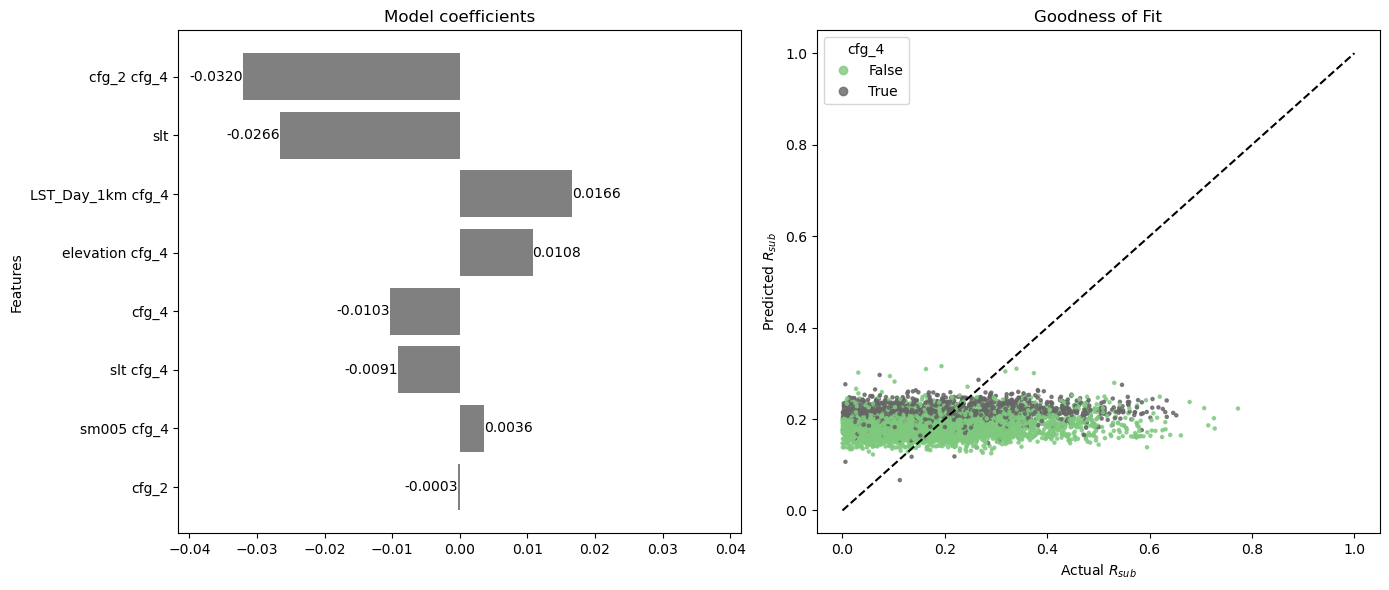

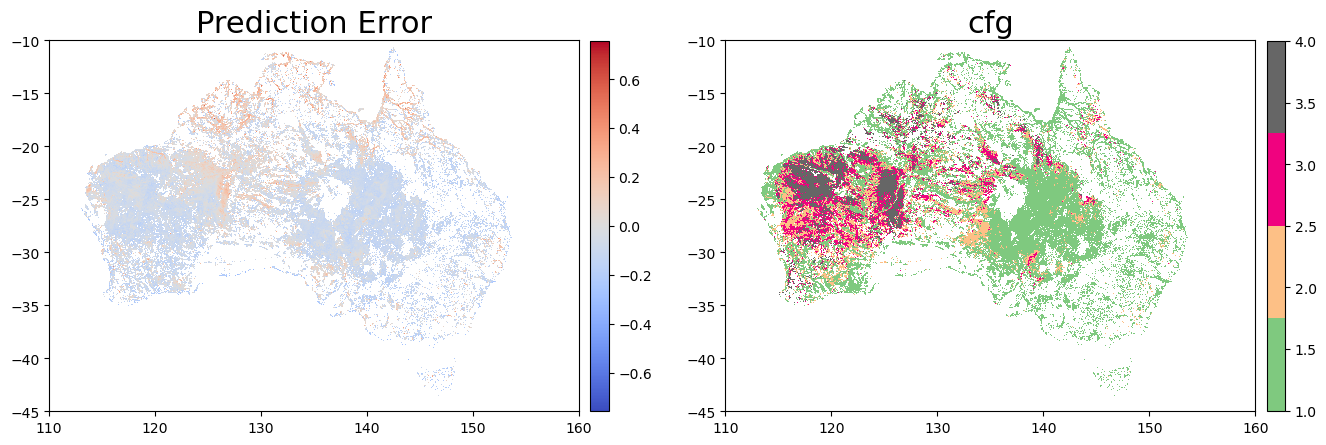

In [70]:
evaluate_model(model = PLSRegression(n_components=5),
               model_name = "PLS",
               POLY_VARIABLES=['cfg_2 cfg_4', 'cfg_2', 'cfg_4', 'slt cfg_4', 'slt', 'sm005 cfg_4', 'LST_Day_1km cfg_4', 'elevation cfg_4'],
               EXP_VARIABLES = ['sm', 'sm005', 'des', 'slt', 'snd', 'elevation', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4'],
               deviation_threshold = 0,
               var_of_interest="cfg_4")

In [ ]:
evaluate_model(model = PLSRegression(n_components=5),
               model_name = "PLS",
               POLY_VARIABLES=['cfg_2 cfg_4', 'cfg_2', 'cfg_4', 'slt cfg_4', 'slt', 'sm005 cfg_4', 'LST_Day_1km cfg_4', 'elevation cfg_4'],
               EXP_VARIABLES = ['sm', 'sm005', 'des', 'slt', 'snd', 'elevation', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4'],
               deviation_threshold = 0.1)

Applied PolynomialFeatures with degree=2. Using 11 selected features.
RMSE: 0.1372
R² Score: 0.0440


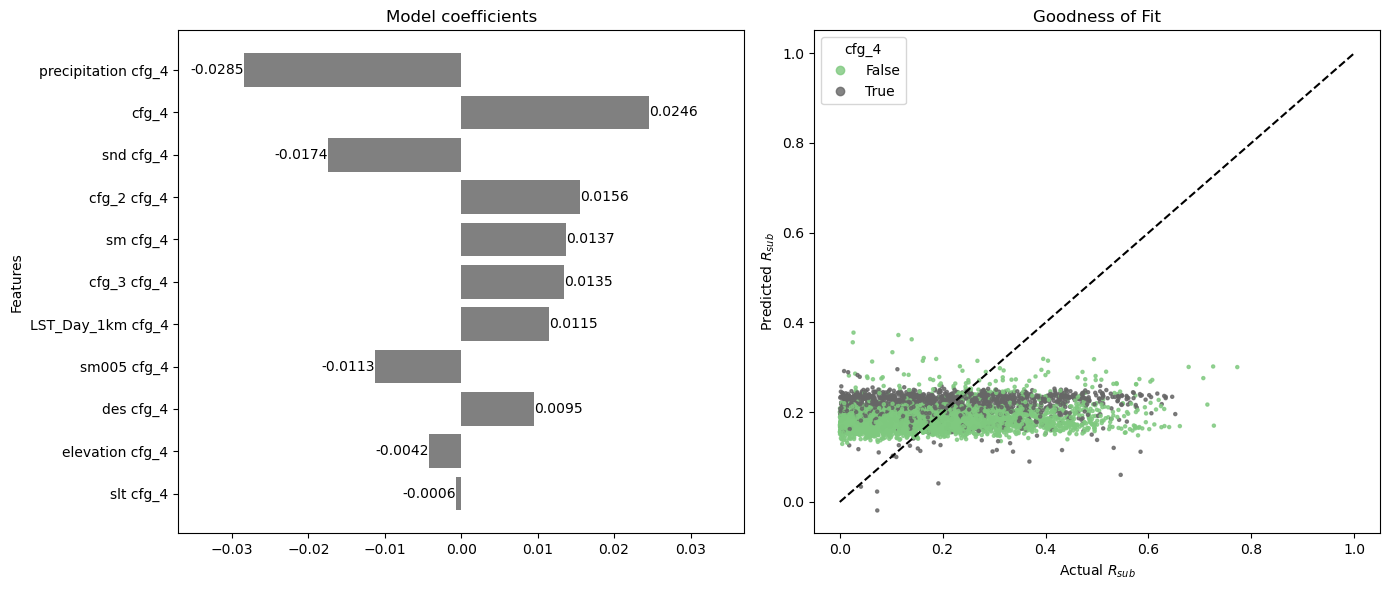

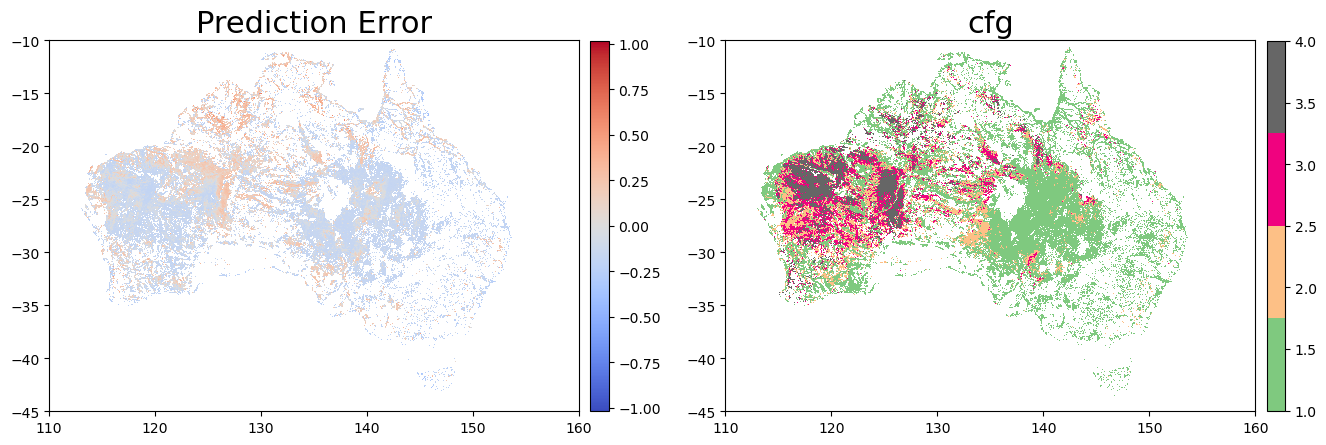

In [35]:
evaluate_model(model = PLSRegression(n_components=5),
               model_name = "PLS",
               POLY_VARIABLES = ["cfg_4"],
               EXP_VARIABLES = ['sm', 'sm005', 'des', 'slt', 'snd', 'elevation', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4'],
               deviation_threshold = 0.15)

Applied PolynomialFeatures with degree=2. Using 11 selected features.
RMSE: 0.1384
R² Score: 0.0268


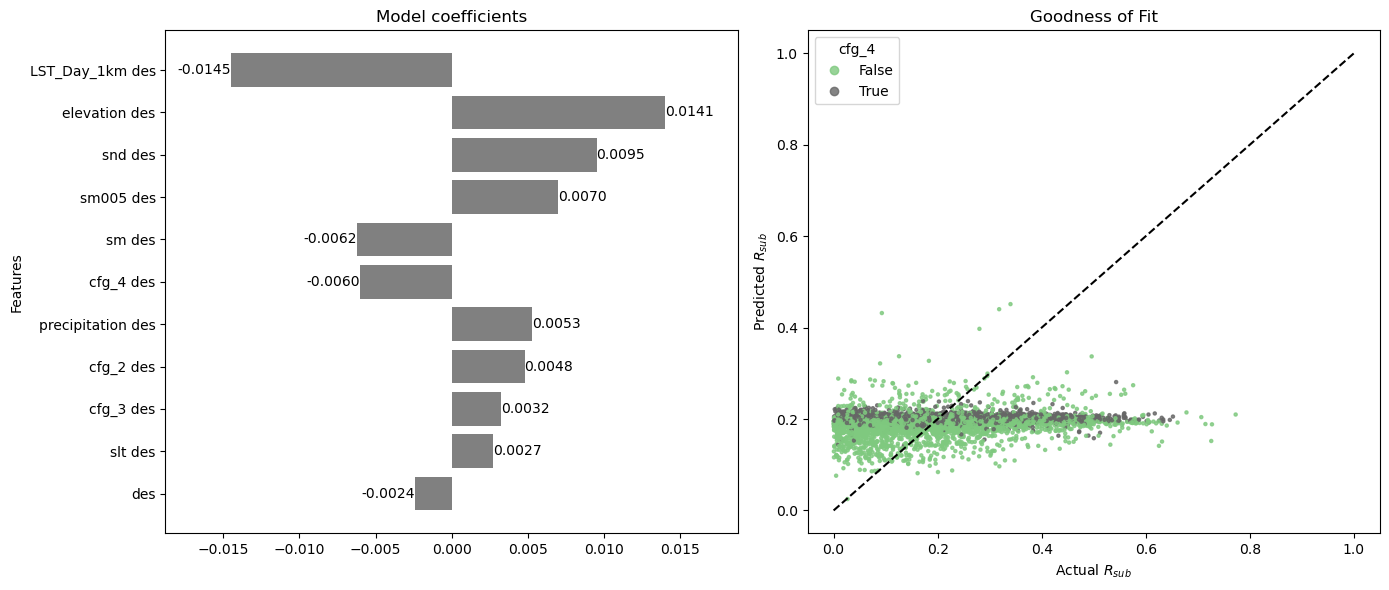

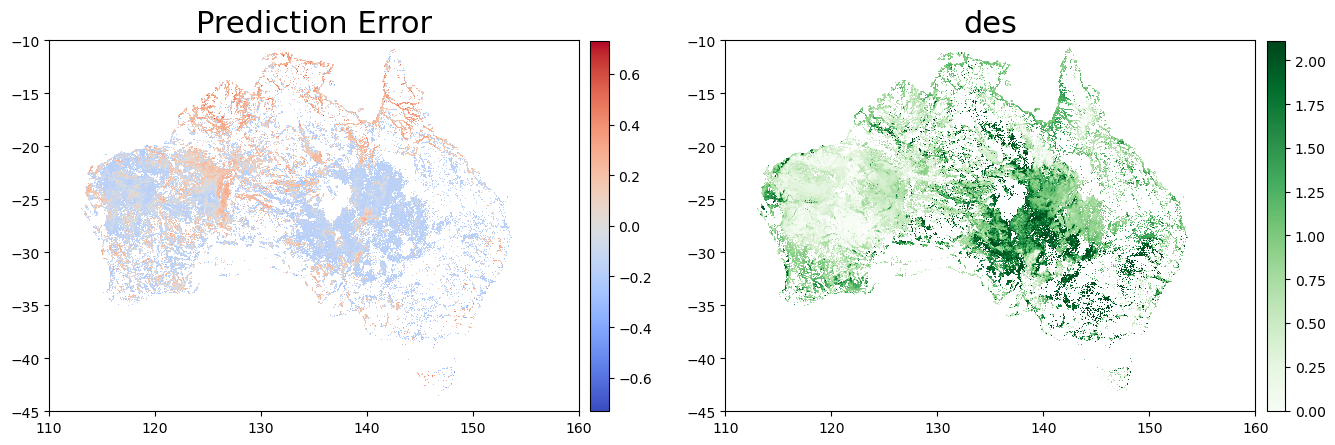

In [36]:
evaluate_model(model = PLSRegression(n_components=5),
               model_name = "PLS",
               POLY_VARIABLES = ["des"],
               EXP_VARIABLES = ['sm', 'sm005', 'slt', 'snd', 'elevation', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4', 'des'],
               deviation_threshold = 0.15)

RMSE: 0.1354
R² Score: 0.0693


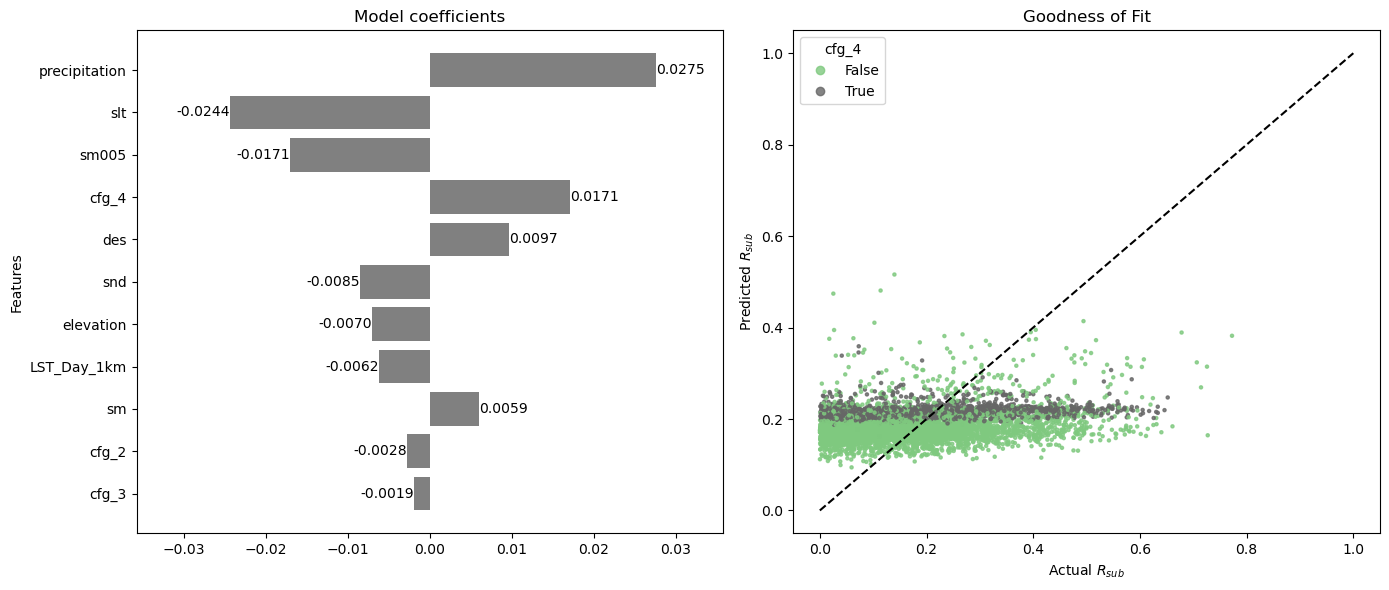

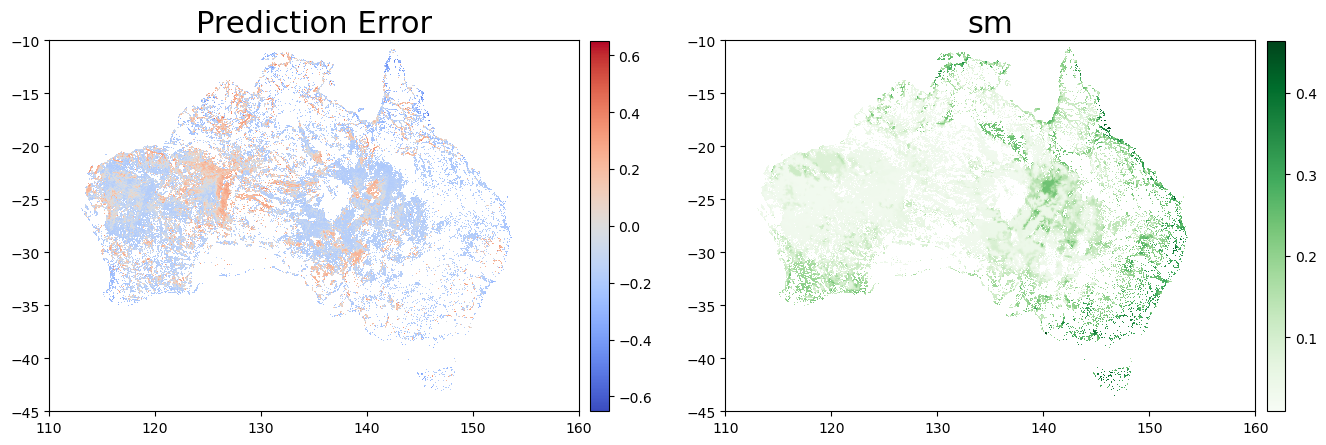

In [37]:
evaluate_model(model = PLSRegression(n_components=5),
               model_name = "PLS",
               POLY_VARIABLES=[],
               EXP_VARIABLES = ['sm', 'sm005', 'des', 'slt', 'snd', 'elevation', 'LST_Day_1km', 'precipitation', 'cfg_2', 'cfg_3', 'cfg_4'],
               deviation_threshold = 0.15)

In [ ]:
### Remember Rsub includes all possible anomalous behaviours not only Subsurface Backscattering!

## References

[1] W. Wagner, G. Lemoine, and H. Rott, “A Method for Estimating Soil Moisture from ERS Scatterometer and Soil Data,” Remote Sensing of Environment, vol. 70, no. 2, pp. 191–207, Nov. 1999, doi: 10.1016/S0034-4257(99)00036-X.    

[2] K. Morrison and W. Wagner, “Explaining Anomalies in SAR and Scatterometer Soil Moisture Retrievals From Dry Soils With Subsurface Scattering,” IEEE Trans. Geosci. Remote Sensing, vol. 58, no. 3, pp. 2190–2197, Mar. 2020, doi: 10.1109/TGRS.2019.2954771.    

[3] W. Wagner et al., “Widespread occurrence of anomalous C-band backscatter signals in arid environments caused by subsurface scattering,” Remote Sensing of Environment, vol. 276, p. 113025, Jul. 2022, doi: 10.1016/j.rse.2022.113025    

[4] B. Raml, M. Vreugdenhil, S. Massart, C. Navacchi, and W. Wagner, “ENABLING GLOBAL SCALE SENTINEL-1 TIME SERIES ANALYSIS THROUGH STREAMING”.    

[5] B. Bauer-Marschallinger, D. Sabel, and W. Wagner, “Optimisation of global grids for high-resolution remote sensing data,” Computers & Geosciences, vol. 72, pp. 84–93, Nov. 2014, doi: 10.1016/j.cageo.2014.07.005.
